In [ ]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
# import tensorflow as tf
# import tensorflow.keras as keras
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# plt.ion()   # interactive mode

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ]),
}



image_datasets = {'train': datasets.CIFAR100('data',train=True,
                                          transform=data_transforms['train'],download=True)
                  ,'val': datasets.CIFAR100('data',train=False,
                                          transform=data_transforms['val'],download=True)}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


CIFAR-100 Dataset: 

No of classes = 100 \\
No of images from each class = 600 \\


aquarium_fish


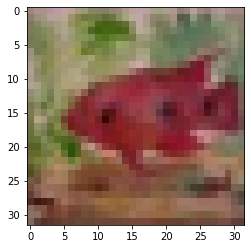

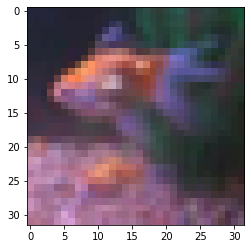

bottle


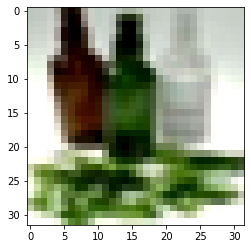

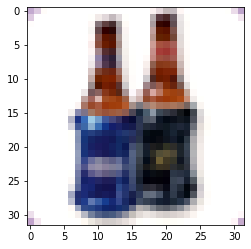

782 157


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


appind=[]
sqind = []
while(len(appind)<2 or len(sqind)<2):
    inputs, classes = next(iter(dataloaders['train']))
    for i in range(len(classes)):
        if(len(appind)==2 and len(sqind)==2):
            break
        if(classes[i]==1 and len(appind)<2):
            appind.append(inputs[i])
        if(classes[i]==9 and len(sqind)<2):
            sqind.append(inputs[i])
print(class_names[1])
imshow(appind[0])
imshow(appind[1])
plt.show()
print(class_names[9])
imshow(sqind[0])
plt.show()
imshow(sqind[1])
plt.show()
print(len(dataloaders['train']),len(dataloaders['val']))

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    acc = []
    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        epoch_time = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            acc.append(epoch_acc.item())
#             print(acc)
            # if(epoch>10):
            #     if(np.mean(acc[-10:])>epoch_acc):
            #         break
            
        # if(epoch>10):
        #         if(np.mean(acc[-10:])>epoch_acc):
        #             break
        print('Epoch time ',time.time()-epoch_time)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# 1.b
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 100)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=60)

train Loss: 2.8499 Acc: 0.3109
val Loss: 1.9258 Acc: 0.4776
Epoch time  55.763360023498535

train Loss: 1.6736 Acc: 0.5368
val Loss: 1.6445 Acc: 0.5394
Epoch time  57.77497148513794

train Loss: 1.2350 Acc: 0.6481
val Loss: 1.5507 Acc: 0.5733
Epoch time  58.09333062171936

train Loss: 0.9281 Acc: 0.7276
val Loss: 1.5609 Acc: 0.5766
Epoch time  58.177814960479736

train Loss: 0.6928 Acc: 0.7936
val Loss: 1.6388 Acc: 0.5824
Epoch time  57.26201128959656

train Loss: 0.5224 Acc: 0.8419
val Loss: 1.6440 Acc: 0.5908
Epoch time  58.15801215171814

train Loss: 0.3903 Acc: 0.8827
val Loss: 1.7283 Acc: 0.5881
Epoch time  59.35018253326416

train Loss: 0.2941 Acc: 0.9104
val Loss: 1.7839 Acc: 0.5945
Epoch time  58.512551069259644

train Loss: 0.2341 Acc: 0.9298
val Loss: 1.8884 Acc: 0.5842
Epoch time  58.34802508354187

train Loss: 0.1951 Acc: 0.9412
val Loss: 1.8662 Acc: 0.5957
Epoch time  58.233871936798096

train Loss: 0.1670 Acc: 0.9500
val Loss: 1.9103 Acc: 0.5982
Epoch time  58.50404477119

In [ ]:
# 1.c
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 100)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Choosing large step_size so that the learning rate is not changed
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10000, gamma=1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

train Loss: 2.7712 Acc: 0.3057
val Loss: 2.6675 Acc: 0.3508
Epoch time  58.030938148498535

train Loss: 2.1802 Acc: 0.4218
val Loss: 2.0859 Acc: 0.4774
Epoch time  57.85194158554077

train Loss: 1.7993 Acc: 0.5077
val Loss: 2.0647 Acc: 0.4725
Epoch time  58.15672492980957

train Loss: 1.5521 Acc: 0.5681
val Loss: 2.3339 Acc: 0.4071
Epoch time  57.89279866218567

train Loss: 1.5433 Acc: 0.5655
val Loss: 1.9238 Acc: 0.5026
Epoch time  57.6814501285553

train Loss: 1.1544 Acc: 0.6612
val Loss: 1.7459 Acc: 0.5435
Epoch time  57.32026720046997

train Loss: 0.9221 Acc: 0.7247
val Loss: 1.8882 Acc: 0.5311
Epoch time  57.45919370651245

train Loss: 0.9180 Acc: 0.7238
val Loss: 1.8197 Acc: 0.5517
Epoch time  57.603549003601074

train Loss: 0.6886 Acc: 0.7892
val Loss: 1.9484 Acc: 0.5411
Epoch time  56.4409384727478

train Loss: 0.4996 Acc: 0.8428
val Loss: 2.0186 Acc: 0.5525
Epoch time  55.63773560523987

train Loss: 0.7799 Acc: 0.7684
val Loss: 2.1421 Acc: 0.5356
Epoch time  55.421449422836304

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 100)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10000, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

train Loss: 4.2924 Acc: 0.0569
val Loss: 3.8239 Acc: 0.1034
Epoch time  31.980154037475586

train Loss: 3.6444 Acc: 0.1322
val Loss: 3.6808 Acc: 0.1663
Epoch time  31.474239349365234

train Loss: 3.3573 Acc: 0.1850
val Loss: 168.0836 Acc: 0.0916
Epoch time  31.48808240890503

train Loss: 3.4314 Acc: 0.1724
val Loss: 3.3322 Acc: 0.2005
Epoch time  30.927753925323486

train Loss: 3.1328 Acc: 0.2295
val Loss: 3.0938 Acc: 0.2479
Epoch time  31.615440130233765

train Loss: 2.9113 Acc: 0.2709
val Loss: 2.9317 Acc: 0.2751
Epoch time  31.68801212310791

train Loss: 2.7537 Acc: 0.3027
val Loss: 2.8398 Acc: 0.2987
Epoch time  31.393277406692505

train Loss: 2.5957 Acc: 0.3343
val Loss: 2.7763 Acc: 0.3128
Epoch time  31.085713148117065

train Loss: 2.4539 Acc: 0.3604
val Loss: 2.7110 Acc: 0.3291
Epoch time  31.286401510238647

train Loss: 2.2735 Acc: 0.3977
val Loss: 2.6343 Acc: 0.3375
Epoch time  31.146859645843506

train Loss: 2.1366 Acc: 0.4286
val Loss: 2.8236 Acc: 0.3339
Epoch time  31.25951

All the three learning rates give very high training accuracies. \\
The first learning rate used gives the highest validation accuracy on the target set. Validation acc = 0.6231 \\
The second learning rate gives a lower accuracy. Validation acc = 0.5794 \\
And the third onne gives the least among the three. Validation acc = 0.0.3886 \\
Therefore the learning rate which changes from 0.0001 to 0.000001 gives the best accuracy

In [ ]:
# 2
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 100)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


In [ ]:
# 2.a
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=1, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10000, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=200)

train Loss: 142.7233 Acc: 0.1478
val Loss: 171.0052 Acc: 0.1797
Epoch time  18.774144172668457

train Loss: 141.3311 Acc: 0.1995
val Loss: 151.4047 Acc: 0.2069
Epoch time  19.278165340423584

train Loss: 138.1913 Acc: 0.2194
val Loss: 159.6138 Acc: 0.2148
Epoch time  23.403469800949097

train Loss: 136.6077 Acc: 0.2316
val Loss: 171.3207 Acc: 0.2133
Epoch time  19.571969509124756

train Loss: 136.5718 Acc: 0.2446
val Loss: 160.7145 Acc: 0.2236
Epoch time  42.624640703201294



In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 100)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10000, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=200)

train Loss: 12.4193 Acc: 0.1522
val Loss: 13.3354 Acc: 0.1967
Epoch time  18.814987421035767

train Loss: 12.9655 Acc: 0.2006
val Loss: 13.8303 Acc: 0.2042
Epoch time  19.121588945388794

train Loss: 12.6137 Acc: 0.2269
val Loss: 14.4234 Acc: 0.2195
Epoch time  18.31628394126892

train Loss: 12.5771 Acc: 0.2405
val Loss: 14.9399 Acc: 0.2203
Epoch time  18.625174283981323

train Loss: 12.5397 Acc: 0.2493
val Loss: 16.4353 Acc: 0.2211
Epoch time  18.258662223815918

train Loss: 12.3467 Acc: 0.2607
val Loss: 14.9972 Acc: 0.2243
Epoch time  18.06866192817688

train Loss: 12.5186 Acc: 0.2616
val Loss: 16.0285 Acc: 0.2395
Epoch time  18.48176622390747

train Loss: 12.3498 Acc: 0.2734
val Loss: 15.5772 Acc: 0.2353
Epoch time  18.45037579536438

train Loss: 12.3422 Acc: 0.2770
val Loss: 16.9008 Acc: 0.2216
Epoch time  18.900713205337524

train Loss: 12.3976 Acc: 0.2786
val Loss: 14.9404 Acc: 0.2392
Epoch time  18.39568567276001

train Loss: 12.4143 Acc: 0.2840
val Loss: 16.1833 Acc: 0.2364
Epo

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 100)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10000, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=200)

train Loss: 3.5442 Acc: 0.2114
val Loss: 3.3559 Acc: 0.2617
Epoch time  19.403121948242188

train Loss: 3.1341 Acc: 0.2759
val Loss: 3.4352 Acc: 0.2708
Epoch time  18.895296573638916

train Loss: 2.9919 Acc: 0.3022
val Loss: 3.2662 Acc: 0.2799
Epoch time  19.361782789230347

train Loss: 2.9110 Acc: 0.3138
val Loss: 3.2119 Acc: 0.2892
Epoch time  18.928969860076904

train Loss: 2.8296 Acc: 0.3280
val Loss: 3.3056 Acc: 0.3007
Epoch time  19.208881616592407

train Loss: 2.7768 Acc: 0.3367
val Loss: 3.2525 Acc: 0.2963
Epoch time  18.850311994552612

train Loss: 2.7262 Acc: 0.3470
val Loss: 3.3176 Acc: 0.2941
Epoch time  19.041600942611694

train Loss: 2.6983 Acc: 0.3518
val Loss: 3.1771 Acc: 0.3066
Epoch time  19.048458337783813

train Loss: 2.6522 Acc: 0.3611
val Loss: 3.2359 Acc: 0.3032
Epoch time  18.52427339553833

train Loss: 2.6277 Acc: 0.3655
val Loss: 3.1331 Acc: 0.3037
Epoch time  18.40889811515808

train Loss: 2.5934 Acc: 0.3689
val Loss: 3.1166 Acc: 0.3104
Epoch time  18.8798937

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 100)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10000, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=200)

train Loss: 3.9935 Acc: 0.1467
val Loss: 3.5322 Acc: 0.2287
Epoch time  19.959953546524048

train Loss: 3.3874 Acc: 0.2439
val Loss: 3.2941 Acc: 0.2613
Epoch time  20.366072416305542

train Loss: 3.1817 Acc: 0.2698
val Loss: 3.2008 Acc: 0.2737
Epoch time  19.445040225982666

train Loss: 3.0662 Acc: 0.2885
val Loss: 3.0898 Acc: 0.2850
Epoch time  19.50485372543335

train Loss: 2.9790 Acc: 0.2996
val Loss: 3.0586 Acc: 0.2926
Epoch time  19.982303857803345

train Loss: 2.9200 Acc: 0.3099
val Loss: 3.0265 Acc: 0.2957
Epoch time  20.21051859855652

train Loss: 2.8776 Acc: 0.3145
val Loss: 2.9862 Acc: 0.3019
Epoch time  19.518339157104492

train Loss: 2.8393 Acc: 0.3210
val Loss: 2.9958 Acc: 0.3021
Epoch time  19.458975315093994

train Loss: 2.8078 Acc: 0.3263
val Loss: 2.9452 Acc: 0.3074
Epoch time  19.709296941757202

train Loss: 2.7755 Acc: 0.3326
val Loss: 2.9599 Acc: 0.3092
Epoch time  19.517035484313965

train Loss: 2.7530 Acc: 0.3359
val Loss: 2.9319 Acc: 0.3120
Epoch time  19.6189589

2.(a)
The 0.001 learning rate gives the best accuracy on the target dataset = 0.3355



2.(b) The finetuning approach gave better results than the feature extraction approach. Among all the models, the finetuning model with a small learning rate ranging from 0.0001 to 0.000001 gave the best accuracy. This is because we expect the pretrained weights to be relatively good estimates and high learning rates may distort them too quickly.
The feature extractor model may have given low accuracies because the ImageNet dataset which it is trained on might not be that similar to the CIFAR-100 dataset. So the feature extractioin is not as good as expected. As the resnet model has batch normalization layers, which might be input dependent, changing the input distribution drastically may affect the results.

# Problem 2

1. In the paper which uses weakly supervised learning, they use noisy labels(hashtags) to improve the accuracy.

Whereas the semi-supervised learninng paper uses a teacher-student model in which a teacher model is trained using labeled data and is used to label unseen unlabeled data.


2.(a) Yes, the models trained using hashtags are robust again noise labels. In the paper they pre-trained a ResNeXt model with 1B images and 17k labels where p% of the labels were randomly replaced with noise. p = 10% decreased the top-1 accuracy on ImageNet by only around 1%, and p = 25% decreased accuracy by about 2%.


(b) Hashtags follow Zipfian distribution and it may reduce the impact of some of the classes on the overall training loss. Resampling the hashtag distribution ensures that all classes are included in training. Resampling of the hashtag distribution is important in order to obtain good transfer to ImageNet image-classification tasks. Using uniform or square-root sampling leads to an accuracy improvement of 5 to 6% irrespective of the number of ImageNet classes in the transfer task.

3.a) The goal is to improve performance using unlabeled data. This paper suggest using two models, teacher and student so that one model can benefit from the other. The teacher model is trained using labeled data. The unlabeled data is then passed through the teacher model and top-K labels from each target variable are selected from this to create a new labeled dataset. The student model is then trained on this new dataset after which it is finetuned on the previvous labeled dataset. So the student model uses the labels generated from the teacher model to train itself.

Distillation is a procedure used to compress a large model into a smaller one. In distillation the teacher model makes prediction on unlabelled data, and the inferred labels are used to train the student in a supervised fashion which is very similar to the model suggested in the paper. Therefore the teacher-student model is a type of distillation technique.

The teacher and student model is needed since the teacher model selects the top-K images in the unlabeled dataset and this dataset allows us generate a new training set. Since the student model is always 'smaller' than the teacher model, it is a distillation technique.

b) K is the number of examples that are selected from the unlabeled dataset U for each target label. P corresponds to the number of relevant classes of an image. The reason for choosing P > 1 is that it is difficult to identify
accurately under-represented objects, or some may be cut-off by more prominent co-occurring objects.

c) The new labeled dataset is created by selecting the top-K images from each class from the predictions of the teacher model.
Yes an image from this dataset can belong to more than one class. As P>1, if the scores of the image for more than one class lies in the top K scores of those respectiive classes then it will belong to all such classes.

d) Increasing K initially increases the amount of data present for the student model and thus causes the accuracy to increase. But upon increasing K further, we observe a drop ini accuracy because this causes incorrect results from the output of the teacher model to be added to the new labeled data. As this increases the noise in the labels of the new dataset the accuracy decreases.

# Problem 3

1. Achieving peak FLOPS requires customized libraries with intimate knowledge of the underlying hardware. Even specially tuned libraries may fall short of peak execution by as much as 40%. 
Instead of trying to measure and capture every source of inefficiency in every learning framework, the paper suggests taking a small number of representative deep learning workloads which contain convolutions, pooling, dropout, and fully connected layers and run them for a short time on a single GPU. Given observed total throughput and estimated total throughput on this benchmark, fit a scaling constant to estimate a platform percent of peak (PPP) parameter which captures the average relative inefficiency of the platform compared to peak FLOPS.

2. The VGG19 model has a conv3-256 and 2 conv3-512 layers in addition to the VGG16 moodel. Therefore additional FLOPs = 4,161,798,144 = 4162M

The distribution of FLOPs for the VGG16 model is as follows-

CONV:15360M,
POOL:6M,
ReLU:14M,
FC:124M,

Upon adding the additional FLOPs,


The CONV layers FLOPs of the VGG19 network: 19522M

And the total FLOPs of the VGG19 network is: 15503M + 4162M = 19,665M

So the fraction of the total FLOPs attributed by convolution layers 0.9932.

3. The measured time and sum of layerwise timing for forward pass did not match on GPUs. This is because CUDA allows asynchronous programming. Before the time is measured, an API is called to ensure that all cores have finished their tasks. This synchronization before measuring time on the GPUs results in an extra overhead. Thererefore, the sum of layerwise timing on GPUs is longer
than a full forward pass.

In a full forward pass, timing is only recorded at the last layer. Therefore, a core may be assigned with the computation of following layers and thus it can continuously perform the computation without synchronization. For example,
after finishing the multiply-add operations for the matrix multiplication at a CONV layer, a core can continue to calculate the max function of next ReLU layer on the output of multiply-add operations. If layerwise timing is recorded, all cores have to wait until all multiply-add operations of the CONV layer have been completed.

To mitigate the overhead, they keep GPUs iteratively running the process in a way that GPU cores can continuously perform multiply-add operations without synchronization, before recording the end time. Then, the measurement overhead is amortized over all the iterations, giving accurate timing estimates. When the number of iterations is large the measurement overhead becomes insignificant.

4. NVidia Tesla K80: double PPP = 1.87 Tflops.
Forward pass on VGG requires 15503M FLOPs; as such, one forward pass on a K80 would take (15503 x 10^6) / (1.87 x 10^12) = 0.00829037433s so throughput is 120 images/sec.

GoogLeNet: 
Inference time: (1606 x 10^6) / (1.87 x 10^12) = 0.0008588s/image. Throughoutput: 1164 images/sec.

ResNet: 
Inference time: (3922 x 10^6) / (1.87 x 10^12) = 0.0020973s/img. 
Throughput: 476 images/sec.